# Houseprices Challange

## Introduction

### Dataset

### Import Libraries and Define Functions

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
import math
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from scipy import stats

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
def print_nulls(df):
    
    out = df.isnull().sum()*100/df.isnull().isnull().count()
    
    pd.set_option('display.max_rows', len(out))
    print(out)
    pd.reset_option('display.max_rows')

In [3]:
def print_outliers(lower_inner_upper, df):
    
    if lower_inner_upper == 'lower':
        
        print('Continuious Variables', '\n')

        for column in df.select_dtypes(include='number'):
            print(column)
            for threshold in [95, 90, 85, 80, 75]:
                lower_bound = np.percentile(df[column], [100-threshold])[0]
                
                print('Beyond the upper {}th percentile there are {} outliers'.format(threshold, 
                    len((np.where((df[column] < lower_bound))[0]))
                ))
                
            if (df[column].nunique() < 5):
                print('\n')
                print('Possible Categorical Variable')
                print('There are {} unique values'.format(df[column].nunique()))
                print(df[column].value_counts())
            print('\n')
    
    elif lower_inner_upper == 'inner':
        
        print('Continuious Variables', '\n')
    
        for column in df.select_dtypes(include='number'):
            print(column)
            for threshold in [95, 90, 85, 80, 75]:
                alpha = 100 - threshold
                upper_bound, lower_bound = np.percentile(df[column]
                                                         , [(100 - alpha/2), (0 + alpha/2)]) 

                print("Beyond the inner {}th percentile there are {} outliers.".format(threshold,
                        len((np.where((df[column] > upper_bound) 
                                      | (df[column] < lower_bound))[0]))
                    ))

            if (df[column].nunique() < 5):
                print('\n')
                print('Possible Categorical Variable')
                print('There are {} unique values'.format(df[column].nunique()))
                print(df[column].value_counts())
            print('\n')
            
    elif lower_inner_upper == 'upper':
    
        print('Continuious Variables', '\n')

        for column in df.select_dtypes(include='number'):
            print(column)
            for threshold in [95, 90, 85, 80, 75]:
                upper_bound = np.percentile(df[column], [threshold])[0]
                
                print('Beyond the lower {}th percentile there are {} outliers'.format(threshold, 
                    len((np.where((df[column] > upper_bound))[0]))
                ))
                
            if (df[column].nunique() < 5):
                print('\n')
                print('Possible Categorical Variable')
                print('There are {} unique values'.format(df[column].nunique()))
   top_15             print(df[column].value_counts())
            print('\n')
        
        
    
    print('Categorical Variables', '\n')
    
    for column in df.select_dtypes(include='object'):
        print(column)
        print('There are {} unique values'.format(df[column].nunique()))
        print(df[column].value_counts())
        print('\n')

### Load the data

In [4]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

query1 = '''
SELECT
  *
FROM
  houseprices
'''

df = pd.read_sql_query(query1, con=engine)
engine.dispose()

## Data cleaning and EDA

In [6]:
# Move the target variable to be the first column for convience and ease of reading outputs

df = df[['saleprice', 'id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
         'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paveddrive', 'wooddecksf', 'openporchsf',
       'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'poolqc',
       'fence', 'miscfeature', 'miscval', 'mosold', 'yrsold', 'saletype',
       'salecondition']]

In [7]:
# Combine information from some related features for dimension reduction

df['total_square_feet'] = df['totalbsmtsf'] + df['grlivarea']

df['total_full_bath'] = df['fullbath'] + df['bsmtfullbath']

df['total_half_bath'] = df['halfbath'] + df['bsmthalfbath']


# Drop the component features

df.drop(['totalbsmtsf', 'grlivarea', 'fullbath', 'bsmtfullbath', 'halfbath', 'bsmthalfbath'
         , 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf']
        , axis=1, inplace=True)


# Reformat year buit to give the age of the house
df['age'] = 2010 - df['yearbuilt']

# Drop the compnent variable and the correlated year remodeled variable
df.drop(['yearbuilt', 'yearremodadd'], axis=1, inplace=True)

# Additionally drop the 'id' column and some 'garagecars' as this is mostly contained in 'garagearea'

df.drop(['id', 'garagecars'], axis=1, inplace=True)


In [8]:
# According to the data dictionary null values for the following variables mean that house 
# does not include that that feature. This makes filling these values much easier.

df['alley'].fillna('no_alley_access', inplace=True)

df['fence'].fillna('no_fence', inplace=True)

df['masvnrtype'].fillna('no_masonary', inplace=True)

df['masvnrarea'].fillna(0, inplace=True)

for var in ['bsmtqual','bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2']:
    df[var].fillna('no_basement', inplace=True)
    
df['fireplacequ'].fillna('no_fireplace', inplace=True)

for var in['garagetype', 'garagefinish', 'garagequal', 'garagecond']:
  df[var].fillna('no_garage', inplace=True)

df['poolqc'].fillna('no_pool', inplace=True)

df['fence'].fillna('no_fence', inplace=True)

df['miscfeature'].fillna('no_additional_features', inplace=True)


In [9]:
# There is a single observation with a missing value for 'electrical', I'll drop that observation
df.drop(np.where(df['electrical'].isnull())[0], inplace=True)

# 'garageyrblt' presents a problem since ther is no straightforward to fill that value
# it is only moderatly correlated to 'saleprice' I'll drop that column for now

df.drop('garageyrblt', axis=1, inplace=True)

# Lotfrontage contains a significant number of missing values. A little exploration reveals that these are not
# likely homes with no frontage. However it is also not strongly correlated with the target variable. For now
# I will drop it 

df.drop('lotfrontage', axis=1, inplace=True)

In [10]:
print_nulls(df)

saleprice           0.000
mssubclass          0.000
mszoning            0.000
lotarea             0.000
street              0.000
alley               0.000
lotshape            0.000
landcontour         0.000
utilities           0.000
lotconfig           0.000
landslope           0.000
neighborhood        0.000
condition1          0.000
condition2          0.000
bldgtype            0.000
housestyle          0.000
overallqual         0.000
overallcond         0.000
roofstyle           0.000
roofmatl            0.000
exterior1st         0.000
exterior2nd         0.000
masvnrtype          0.000
masvnrarea          0.000
exterqual           0.000
extercond           0.000
foundation          0.000
bsmtqual            0.000
bsmtcond            0.000
bsmtexposure        0.000
bsmtfintype1        0.000
bsmtfintype2        0.000
heating             0.000
heatingqc           0.000
centralair          0.000
electrical          0.000
bedroomabvgr        0.000
kitchenabvgr        0.000
kitchenqual 

In [11]:
# All missing values have been accounted for

In [12]:
# 'mssubclass' needs to be remapped as a categorical feature

subclass_map = { 20 : '1_story_1946_and_newer'
        , 30 : '1_story_1945_and_older'
        , 40 : '1_story_finished_attic_all_ages'
        , 45 : '1_1/2_story_unfinished_attic_all_ages'
        , 50 : '1_1/2_story_finished_attic_all_ages'
        , 60 : '2_story_1946_and_newer'
        , 70 : '2_story_1945_and_older'
        , 75 : '2_1/2_story_all_ages'
        , 80 : 'split_or_multi_level'
        , 85 : 'split_foyer'
        , 90 : 'duplex_all_styles_and_ages'
       , 120 : '1_story_planned_unit_developement_1946_and_newer'
       , 150 : '1_1/2_story_planned_unit_developement_all_ages'
       , 160 : '2_story_planned_unit_developement_1946_and_newer'
       , 180 : 'planned_unit_developement_multilevel'
       , 190 : '2_family_conversion_all_styles_and_ages'
               }

df['mssubclass'].replace(subclass_map, inplace=True)

In [13]:
print_outliers('inner', df)

Continuious Variables 

saleprice
Beyond the inner 95th percentile there are 72 outliers.
Beyond the inner 90th percentile there are 144 outliers.
Beyond the inner 85th percentile there are 220 outliers.
Beyond the inner 80th percentile there are 291 outliers.
Beyond the inner 75th percentile there are 358 outliers.


lotarea
Beyond the inner 95th percentile there are 74 outliers.
Beyond the inner 90th percentile there are 146 outliers.
Beyond the inner 85th percentile there are 220 outliers.
Beyond the inner 80th percentile there are 288 outliers.
Beyond the inner 75th percentile there are 366 outliers.


overallqual
Beyond the inner 95th percentile there are 43 outliers.
Beyond the inner 90th percentile there are 86 outliers.
Beyond the inner 85th percentile there are 86 outliers.
Beyond the inner 80th percentile there are 202 outliers.
Beyond the inner 75th percentile there are 202 outliers.


overallcond
Beyond the inner 95th percentile there are 53 outliers.
Beyond the inner 90th 

There are 8 unique values
1Story    726
2Story    445
1.5Fin    154
SLvl       64
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: housestyle, dtype: int64


roofstyle
There are 6 unique values
Gable      1140
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: roofstyle, dtype: int64


roofmatl
There are 8 unique values
CompShg    1433
Tar&Grv      11
WdShngl       6
WdShake       5
ClyTile       1
Metal         1
Roll          1
Membran       1
Name: roofmatl, dtype: int64


exterior1st
There are 15 unique values
VinylSd    514
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
Stone        2
BrkComm      2
AsphShn      1
CBlock       1
ImStucc      1
Name: exterior1st, dtype: int64


exterior2nd
There are 16 unique values
VinylSd    503
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25

In [14]:
# I'm chosing not to treat outliers in certain features. These include any ordinal ranking features such as 
# 'overallqual' and any variables that include cronological data such as 'yrsold'

# Additionally for certain variables that contain mostly real zero values 
# all non-zero observations would be considered outliers so those variables will not be treated.


for column in ['saleprice', 'lotarea', 'masvnrarea', 'bedroomabvgr', 'totrmsabvgrd'
               , 'fireplaces', 'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch'
               , 'screenporch', 'total_square_feet', 'total_full_bath', 'total_half_bath', 'age']:
    
    df[column] = winsorize(df[column], (0.05, 0.05))

In [15]:
df.corr()['saleprice'].sort_values(ascending=False)

saleprice            1.000
total_square_feet    0.829
overallqual          0.812
garagearea           0.658
total_full_bath      0.619
totrmsabvgrd         0.536
fireplaces           0.489
masvnrarea           0.450
lotarea              0.436
openporchsf          0.395
wooddecksf           0.350
total_half_bath      0.286
bedroomabvgr         0.224
screenporch          0.096
mosold               0.069
poolarea             0.056
threessnporch        0.050
miscval             -0.018
yrsold              -0.029
overallcond         -0.086
kitchenabvgr        -0.153
enclosedporch       -0.167
age                 -0.585
Name: saleprice, dtype: float64

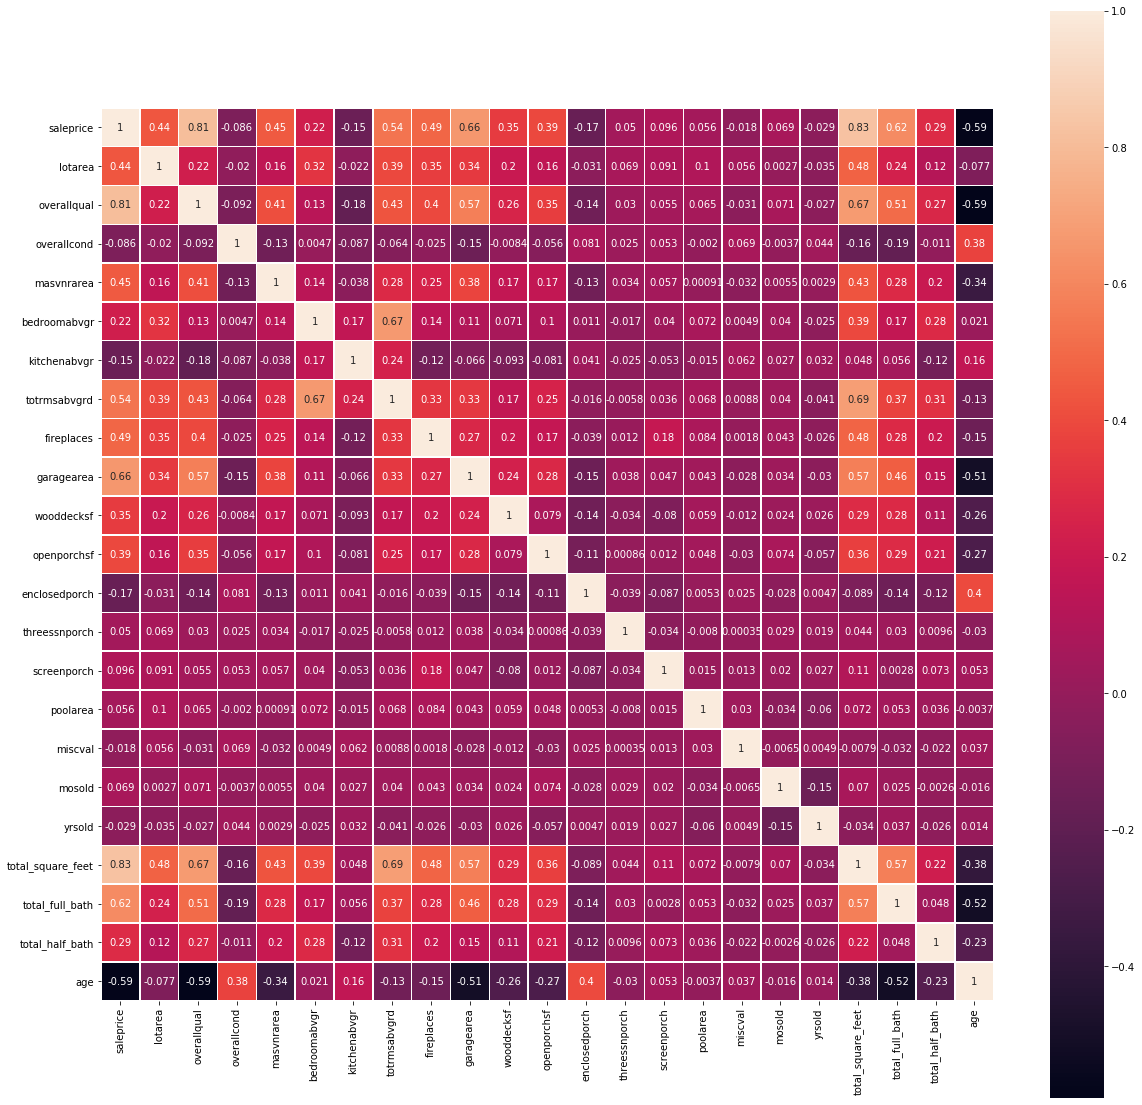

In [16]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), square=True, annot=True, linewidths=.5,)
plt.show()

Visualize the variance of categorical features.

In [17]:
cats = df.select_dtypes(include='object').columns

In [ ]:
plt.figure(figsize=(15, len(cats)*2))
for i, feature in enumerate(cats):
    plt.subplot(len(cats), 2, i+1)
    sns.barplot(df[feature], df['saleprice'])
    plt.title(feature)
    plt.xlabel('')
    plt.xticks(rotation=90)
plt.tight_layout(pad=0.3)
plt.show()


## Feature Selection and Engineering



Using a forward pass style approach I will build a list of features as I iterate through my model

In [56]:
scores = []

features = df.drop('saleprice', axis=1)
y = df['saleprice']

for feature in features.columns:
    X = df[feature]
    
    # encode dummy variables if its categorical
    if X.dtype == 'object':
        X = pd.concat([X, pd.get_dummies(X, drop_first=True)], axis=1)
        X.drop(feature, axis=1, inplace=True)
    
    # reshape it if its continuous
    else:    
        X = X.to_numpy().reshape(-1, 1)
        
    # declare and fit the model then score it and append the score to the list                                    
    lrm = LinearRegression()
    lrm.fit(X, y)
    scores.append([feature,  cross_val_score(lrm, X, y, cv=5).mean()])

In [209]:
# select the 15 variables that best explain the variance in the target

def send(x):
    return x[1]

scores.sort(key=send, reverse=True)

top_15 = [item[0] for item in scores[:15]]

In [210]:
top_15

['total_square_feet',
 'overallqual',
 'neighborhood',
 'exterqual',
 'bsmtqual',
 'kitchenqual',
 'garagearea',
 'total_full_bath',
 'garagefinish',
 'age',
 'fireplacequ',
 'foundation',
 'garagetype',
 'mssubclass',
 'totrmsabvgrd']

In [228]:
top_15_df = df.loc[:, top_15]

In [229]:
for column in top_15_df.columns:
    if top_15_df[column].dtype == 'object':
        top_15_df = pd.concat([top_15_df, pd.get_dummies(top_15_df[column], prefix=column)], axis=1)

In [230]:
top_15_df.drop(['neighborhood_NWAmes', 'exterqual_TA', 'bsmtqual_TA', 'kitchenqual_TA'
                , 'garagefinish_Unf', 'fireplacequ_TA', 'foundation_PConc', 'garagetype_Attchd'
                , 'mssubclass_1_story_1946_and_newer', 'neighborhood', 'exterqual', 'bsmtqual'
               , 'kitchenqual', 'garagefinish', 'fireplacequ', 'foundation', 'garagetype'
               , 'mssubclass'], axis=1, inplace=True)

In [215]:
# check the independence of the categorical variables

top_15_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 73 columns):
 #   Column                                                       Non-Null Count  Dtype
---  ------                                                       --------------  -----
 0   total_square_feet                                            1459 non-null   int64
 1   overallqual                                                  1459 non-null   int64
 2   garagearea                                                   1459 non-null   int64
 3   total_full_bath                                              1459 non-null   int64
 4   age                                                          1459 non-null   int64
 5   totrmsabvgrd                                                 1459 non-null   int64
 6   neighborhood_Blmngtn                                         1459 non-null   uint8
 7   neighborhood_Blueste                                         1459 non-null   uint8
 8   neighbor

In [217]:
X = top_15_df
y = df['saleprice']

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1312)

In [218]:
ols_results = sm.OLS(y_train, X_train).fit()

ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     121.4
Date:                Mon, 14 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:26:03   Log-Likelihood:                -12440.
No. Observations:                1094   AIC:                         2.503e+04
Df Residuals:                    1021   BIC:                         2.539e+04
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
const                                                        2136.3796   9405.574      0.227      0.820   -1.63e+04    2.06e+04
total_square_feet                                              36.4452      2.184     16.687      0.000      32.160      40.731
overallqual                                                  7232.7848    993.414      7.281      0.000    5283.418    9182.151
garagearea                                                     36.8504      5.818      6.334      0.000      25.433      48.268
total_full_bath                                              8100.5408   1388.568      5.834      0.000    5375.768    1.08e+04
age                                                           -50.3103     81.600     -0.617      0.538    -210.434     109.814
totrmsabvgrd                                                -1819.7517    812.840     -2.239      0.025   -3414.780    -224.723
neighborhood_Blmngtn                                         1867.4646   8574.675      0.218      0.828    -1.5e+04    1.87e+04
neighborhood_Blueste                                         3262.1278   1.67e+04      0.196      0.845   -2.94e+04     3.6e+04
neighborhood_BrDale                                          1.147e+04   8614.288      1.332      0.183   -5430.186    2.84e+04
neighborhood_BrkSide                                         9958.3008   5867.415      1.697      0.090   -1555.271    2.15e+04
neighborhood_ClearCr                                         2.553e+04   6187.744      4.126      0.000    1.34e+04    3.77e+04
neighborhood_CollgCr                                         6728.3266   4411.723      1.525      0.128   -1928.753    1.54e+04
neighborhood_Crawfor                                         2.958e+04   5594.739      5.287      0.000    1.86e+04    4.06e+04
neighborhood_Edwards                                        -4149.3768   4730.576     -0.877      0.381   -1.34e+04    5133.386
neighborhood_Gilbert                                         4401.6078   4856.543      0.906      0.365   -5128.339    1.39e+04
neighborhood_IDOTRR                                         -1162.8762   6554.002     -0.177      0.859    -1.4e+04    1.17e+04
neighborhood_MeadowV                                        -6340.3345   9418.060     -0.673      0.501   -2.48e+04    1.21e+04
neighborhood_Mitchel                                          536.1854   5139.980      0.104      0.917   -9549.948    1.06e+04
neighborhood_NAmes                                           -483.8196   3941.017     -0.123      0.902   -8217.238    7249.598
neighborhood_NPkVill                                         7309.2389   9009.166      0.811      0.417   -1.04e+04     2.5e+04
neighborhoo

In [231]:
# keep total_square_feet and transform or drop the correlated variables

# transform quality into a binary categorical
top_15_df['is_high_qual'] = round(top_15_df['overallqual']/10)
top_15_df.drop('overallqual', axis=1, inplace=True)

# combine the garage area with the house area
top_15_df['total_sf_with_garage'] = top_15_df['total_square_feet'] + top_15_df['garagearea']

# drop other size measurements 
top_15_df.drop(['totrmsabvgrd', 'total_full_bath', 'total_square_feet', 'garagearea'], axis=1, inplace=True)

In [232]:
X = top_15_df
y = df['saleprice']

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1312)

In [233]:
ols_results = sm.OLS(y_train, X_train).fit()

ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     116.5
Date:                Mon, 14 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:39:09   Log-Likelihood:                -12482.
No. Observations:                1094   AIC:                         2.510e+04
Df Residuals:                    1024   BIC:                         2.545e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
const                                                        4.024e+04   7721.772      5.212      0.000    2.51e+04    5.54e+04
age                                                          -144.3122     83.254     -1.733      0.083    -307.680      19.056
neighborhood_Blmngtn                                        -4647.8453   8862.733     -0.524      0.600    -2.2e+04    1.27e+04
neighborhood_Blueste                                          965.0937   1.73e+04      0.056      0.955   -3.29e+04    3.49e+04
neighborhood_BrDale                                          9380.9670   8929.584      1.051      0.294   -8141.407    2.69e+04
neighborhood_BrkSide                                         8652.4498   6036.018      1.433      0.152   -3191.929    2.05e+04
neighborhood_ClearCr                                         2.488e+04   6363.031      3.910      0.000    1.24e+04    3.74e+04
neighborhood_CollgCr                                         5961.9410   4583.695      1.301      0.194   -3032.567     1.5e+04
neighborhood_Crawfor                                         2.924e+04   5754.705      5.081      0.000    1.79e+04    4.05e+04
neighborhood_Edwards                                        -4637.0270   4894.761     -0.947      0.344   -1.42e+04    4967.880
neighborhood_Gilbert                                         2708.9198   5005.989      0.541      0.589   -7114.248    1.25e+04
neighborhood_IDOTRR                                         -2190.6633   6787.976     -0.323      0.747   -1.55e+04    1.11e+04
neighborhood_MeadowV                                        -1.351e+04   9823.023     -1.376      0.169   -3.28e+04    5763.682
neighborhood_Mitchel                                        -1039.2859   5312.046     -0.196      0.845   -1.15e+04    9384.453
neighborhood_NAmes                                          -2416.5710   4075.756     -0.593      0.553   -1.04e+04    5581.217
neighborhood_NPkVill                                         5804.4471   9318.264      0.623      0.533   -1.25e+04    2.41e+04
neighborhood_NoRidge                                         3.845e+04   5756.814      6.679      0.000    2.72e+04    4.97e+04
neighborhood_NridgHt                                         2.682e+04   5605.507      4.785      0.000    1.58e+04    3.78e+04
neighborhood_OldTown                                        -6434.8994   5362.952     -1.200      0.230    -1.7e+04    4088.732
neighborhood_SWISU                                          -2658.5372   7154.390     -0.372      0.710   -1.67e+04    1.14e+04
neighborhood_Sawyer                                         -1987.5483   4849.052     -0.410      0.682   -1.15e+04    7527.667
neighborhoo

In [332]:
kept_features =[
 'neighborhood',
    'exterqual',
 'bsmtqual',
 'totrmsabvgrd', 'kitchenqual',
  'age',
 'fireplacequ',
 'garagetype',
 'mssubclass',
    'total_square_feet']

new_stack = df.loc[:, kept_features]

In [333]:
for column in new_stack.columns:
    if new_stack[column].dtype == 'object':
        new_stack = pd.concat([new_stack, pd.get_dummies(new_stack[column], prefix=column)], axis=1)


new_stack.drop(['exterqual_TA', 'bsmtqual_TA', 'kitchenqual_TA'
                , 'fireplacequ_TA', 'garagetype_Attchd'
                , 'mssubclass_1_story_1946_and_newer', 'neighborhood', 'exterqual', 'bsmtqual'
               , 'kitchenqual', 'fireplacequ', 'garagetype'
               , 'mssubclass'], axis=1, inplace=True)

In [334]:
new_stack['is_high_quality'] = round(df['overallqual']/10)


In [335]:
X = new_stack
y = df['saleprice']

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1312)

results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     122.0
Date:                Mon, 14 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:04:10   Log-Likelihood:                -12515.
No. Observations:                1094   AIC:                         2.516e+04
Df Residuals:                    1031   BIC:                         2.547e+04
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
const                                                        6.496e+04   6134.796     10.588      0.000    5.29e+04     7.7e+04
age                                                          -226.3377     79.851     -2.835      0.005    -383.026     -69.649
total_square_feet                                              42.7815      1.760     24.308      0.000      39.328      46.235
neighborhood_Blmngtn                                        -7542.8917   7880.613     -0.957      0.339    -2.3e+04    7920.979
neighborhood_Blueste                                         6878.6284   1.66e+04      0.414      0.679   -2.57e+04    3.95e+04
neighborhood_BrDale                                          3960.3827   7931.748      0.499      0.618   -1.16e+04    1.95e+04
neighborhood_BrkSide                                        -1071.8802   4668.986     -0.230      0.818   -1.02e+04    8089.919
neighborhood_ClearCr                                         2.024e+04   5571.978      3.632      0.000    9304.586    3.12e+04
neighborhood_CollgCr                                        -2515.3159   3060.094     -0.822      0.411   -8520.040    3489.408
neighborhood_Crawfor                                         1.887e+04   4535.504      4.160      0.000    9969.272    2.78e+04
neighborhood_Edwards                                        -1.324e+04   3330.059     -3.975      0.000   -1.98e+04   -6701.878
neighborhood_Gilbert                                        -6983.0683   3701.696     -1.886      0.060   -1.42e+04     280.649
neighborhood_IDOTRR                                         -8286.7512   5605.092     -1.478      0.140   -1.93e+04    2711.939
neighborhood_MeadowV                                         -1.79e+04   8921.714     -2.006      0.045   -3.54e+04    -390.301
neighborhood_Mitchel                                        -8217.8421   4078.539     -2.015      0.044   -1.62e+04    -214.656
neighborhood_NAmes                                          -9535.5733   2626.935     -3.630      0.000   -1.47e+04   -4380.824
neighborhood_NPkVill                                         2948.6520   8514.467      0.346      0.729   -1.38e+04    1.97e+04
neighborhood_NWAmes                                         -5087.0327   3726.405     -1.365      0.173   -1.24e+04    2225.171
neighborhood_NoRidge                                         3.289e+04   4851.900      6.779      0.000    2.34e+04    4.24e+04
neighborhood_NridgHt                                         2.048e+04   4157.028      4.927      0.000    1.23e+04    2.86e+04
neighborhood_OldTown                                        -1.485e+04   3915.125     -3.793      0.000   -2.25e+04   -7167.268
neighborhoo

In [324]:
X = new_stack
y = df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1312)



0.8723500153300606

In [326]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)



print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.8805697743050802
-----Test set statistics-----
R-squared of the model in the test set is: 0.8723500153300606
Mean absolute error of the prediction is: 17406.380471527613
Mean squared error of the prediction is: 526066041.07953274
Root mean squared error of the prediction is: 22936.12960112348
Mean absolute percentage error of the prediction is: 10.875786550119438


In [ ]:
# transform

In [182]:
new_stack = pd.DataFrame()

new_stack['saleprice'] = top_15_df['saleprice']
new_stack['total_square_feet'] = top_15_df['total_square_feet']

new_stack = pd.concat([new_stack, pd.get_dummies(top_15_df['bsmtqual'])], axis=1) 

In [183]:
new_stack.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   saleprice          1459 non-null   int64
 1   total_square_feet  1459 non-null   int64
 2   Ex                 1459 non-null   uint8
 3   Fa                 1459 non-null   uint8
 4   Gd                 1459 non-null   uint8
 5   TA                 1459 non-null   uint8
 6   no_basement        1459 non-null   uint8
dtypes: int64(2), uint8(5)
memory usage: 41.3 KB


In [175]:
new_stack.columns

Index(['saleprice', 'Ex', 'Fa', 'Gd', 'TA', 'no_basement'], dtype='object')

In [185]:
##
Ex = new_stack[new_stack['Ex'] == 1]


##
Fa = new_stack[new_stack['Fa'] == 1]

##
Gd = new_stack[new_stack['Gd'] == 1]

##
TA = new_stack[new_stack['TA'] == 1]

##
no_basement = new_stack[new_stack['no_basement'] == 1]



In [186]:
stats.kruskal(Ex['total_square_feet'], Fa['total_square_feet'], Gd['total_square_feet']
              , TA['total_square_feet'], no_basement['total_square_feet'])

KruskalResult(statistic=409.76562523749334, pvalue=2.1584656193843534e-87)

In [179]:
mask

,saleprice,Ex,Fa,Gd,TA,no_basement
6,307000,1,0,0,0,0
11,328000,1,0,0,0,0
20,325300,1,0,0,0,0
27,306000,1,0,0,0,0
32,179900,1,0,0,0,0
...,...,...,...,...,...,...
1388,328000,1,0,0,0,0
1405,275000,1,0,0,0,0
1437,328000,1,0,0,0,0
1440,191000,1,0,0,0,0


In [ ]:
kept_features = ['total_square_feet', 'garagarea', 'total_full_bath', 'age', 'is_high_qual', 'neighborhood', '']

NameError: name 'now' is not defined

In [190]:
name

{1: [], 'h': {}}

In [156]:
top_15_df['is_high_qual'] = round(top_15_df['overallqual']/10)

In [158]:
top_15_df.drop(['overallqual', 'totrmsabvgrd'], axis=1, inplace=True )

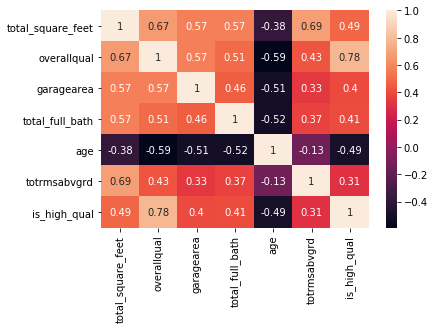

In [157]:
sns.heatmap(top_15_df.corr(), annot=True)

In [342]:
# With a11 15 variables retained and untransformed resulting in multicolinearity problems 


kept = [
    'total_square_feet',
 'overallqual',
 'neighborhood',
 'exterqual',
 'bsmtqual',
 'kitchenqual',
 'garagearea',
 'total_full_bath',
 'garagefinish',
 'age',
 'fireplacequ',
 'foundation',
 'garagetype',
 'mssubclass',
 'totrmsabvgrd']

new_stack = df.loc[:, kept]

In [343]:
for column in new_stack.columns:
    if new_stack[column].dtype == 'object':
        new_stack = pd.concat([new_stack, pd.get_dummies(new_stack[column], prefix=column)], axis=1)

In [344]:
new_stack.drop(['neighborhood_NWAmes', 'exterqual_TA', 'bsmtqual_TA', 'kitchenqual_TA'
                , 'garagefinish_Unf', 'fireplacequ_TA', 'foundation_PConc', 'garagetype_Attchd'
                , 'mssubclass_1_story_1946_and_newer', 'neighborhood', 'exterqual', 'bsmtqual'
               , 'kitchenqual', 'garagefinish', 'fireplacequ', 'foundation', 'garagetype'
               , 'mssubclass'], axis=1, inplace=True)

In [345]:
X = new_stack
y = df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1312)

lrm = LinearRegression()

lrm.fit(X_train, y_train)

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)



print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1312)

results = sm.OLS(y_train, X_train).fit()
results.summary()

R-squared of the model in the training set is: 0.8954444204818662
-----Test set statistics-----
R-squared of the model in the test set is: 0.8879084986487185
Mean absolute error of the prediction is: 16059.556495275094
Mean squared error of the prediction is: 461947038.2781501
Root mean squared error of the prediction is: 21492.953223746383
Mean absolute percentage error of the prediction is: 10.075827096153697


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     121.4
Date:                Mon, 14 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:11:38   Log-Likelihood:                -12440.
No. Observations:                1094   AIC:                         2.503e+04
Df Residuals:                    1021   BIC:                         2.539e+04
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
const                                                        2136.3796   9405.574      0.227      0.820   -1.63e+04    2.06e+04
total_square_feet                                              36.4452      2.184     16.687      0.000      32.160      40.731
overallqual                                                  7232.7848    993.414      7.281      0.000    5283.418    9182.151
garagearea                                                     36.8504      5.818      6.334      0.000      25.433      48.268
total_full_bath                                              8100.5408   1388.568      5.834      0.000    5375.768    1.08e+04
age                                                           -50.3103     81.600     -0.617      0.538    -210.434     109.814
totrmsabvgrd                                                -1819.7517    812.840     -2.239      0.025   -3414.780    -224.723
neighborhood_Blmngtn                                         1867.4646   8574.675      0.218      0.828    -1.5e+04    1.87e+04
neighborhood_Blueste                                         3262.1278   1.67e+04      0.196      0.845   -2.94e+04     3.6e+04
neighborhood_BrDale                                          1.147e+04   8614.288      1.332      0.183   -5430.186    2.84e+04
neighborhood_BrkSide                                         9958.3008   5867.415      1.697      0.090   -1555.271    2.15e+04
neighborhood_ClearCr                                         2.553e+04   6187.744      4.126      0.000    1.34e+04    3.77e+04
neighborhood_CollgCr                                         6728.3266   4411.723      1.525      0.128   -1928.753    1.54e+04
neighborhood_Crawfor                                         2.958e+04   5594.739      5.287      0.000    1.86e+04    4.06e+04
neighborhood_Edwards                                        -4149.3768   4730.576     -0.877      0.381   -1.34e+04    5133.386
neighborhood_Gilbert                                         4401.6078   4856.543      0.906      0.365   -5128.339    1.39e+04
neighborhood_IDOTRR                                         -1162.8762   6554.002     -0.177      0.859    -1.4e+04    1.17e+04
neighborhood_MeadowV                                        -6340.3345   9418.060     -0.673      0.501   -2.48e+04    1.21e+04
neighborhood_Mitchel                                          536.1854   5139.980      0.104      0.917   -9549.948    1.06e+04
neighborhood_NAmes                                           -483.8196   3941.017     -0.123      0.902   -8217.238    7249.598
neighborhood_NPkVill                                         7309.2389   9009.166      0.811      0.417   -1.04e+04     2.5e+04
neighborhoo

### Limit variables

In [351]:
kept = [
    'neighborhood',
 'exterqual',
 'bsmtqual',
 'kitchenqual',
 'total_full_bath',
 'age',
 'fireplacequ',
 'foundation',
 'garagetype',
 'mssubclass',]

new_stack = df.loc[:, kept]

In [352]:
for column in new_stack.columns:
    if new_stack[column].dtype == 'object':
        new_stack = pd.concat([new_stack, pd.get_dummies(new_stack[column], prefix=column)], axis=1)

In [353]:
new_stack.drop(['neighborhood_NWAmes', 'exterqual_TA', 'bsmtqual_TA', 'kitchenqual_TA'
                ,  'fireplacequ_TA', 'foundation_PConc', 'garagetype_Attchd'
                , 'mssubclass_1_story_1946_and_newer', 'neighborhood', 'exterqual', 'bsmtqual'
               , 'kitchenqual', 'fireplacequ', 'foundation', 'garagetype'
               , 'mssubclass'], axis=1, inplace=True)

In [354]:
# These two variables have the strongest explanatory power and have the stronget colinearity. 
# Does combining them help?

new_stack['square+feet_quality_product'] = df['overallqual'] * df['total_square_feet']

In [355]:
X = new_stack
y = df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1312)

lrm = LinearRegression()

lrm.fit(X_train, y_train)

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)



print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1312)

results = sm.OLS(y_train, X_train).fit()
results.summary()

R-squared of the model in the training set is: 0.8914057569255548
-----Test set statistics-----
R-squared of the model in the test set is: 0.8990375074870207
Mean absolute error of the prediction is: 15155.548196241785
Mean squared error of the prediction is: 416082609.576159
Root mean squared error of the prediction is: 20398.1030876932
Mean absolute percentage error of the prediction is: 9.499032985258891


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     125.7
Date:                Mon, 14 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:25:38   Log-Likelihood:                -12461.
No. Observations:                1094   AIC:                         2.506e+04
Df Residuals:                    1026   BIC:                         2.540e+04
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
const                                                        6.989e+04   6755.087     10.346      0.000    5.66e+04    8.31e+04
total_full_bath                                              1.062e+04   1370.511      7.750      0.000    7931.897    1.33e+04
age                                                           -66.2792     81.089     -0.817      0.414    -225.399      92.841
neighborhood_Blmngtn                                         4669.3184   8639.570      0.540      0.589   -1.23e+04    2.16e+04
neighborhood_Blueste                                         9077.1654   1.68e+04      0.539      0.590    -2.4e+04    4.21e+04
neighborhood_BrDale                                          6917.3091   8753.844      0.790      0.430   -1.03e+04    2.41e+04
neighborhood_BrkSide                                         8727.4695   5906.635      1.478      0.140   -2862.995    2.03e+04
neighborhood_ClearCr                                         3.158e+04   6208.942      5.087      0.000    1.94e+04    4.38e+04
neighborhood_CollgCr                                         3988.8943   4454.890      0.895      0.371   -4752.843    1.27e+04
neighborhood_Crawfor                                         2.703e+04   5623.921      4.807      0.000     1.6e+04    3.81e+04
neighborhood_Edwards                                        -6474.4813   4777.456     -1.355      0.176   -1.58e+04    2900.219
neighborhood_Gilbert                                         1867.7019   4860.040      0.384      0.701   -7669.051    1.14e+04
neighborhood_IDOTRR                                         -1878.5449   6641.306     -0.283      0.777   -1.49e+04    1.12e+04
neighborhood_MeadowV                                        -5961.0496   9501.248     -0.627      0.531   -2.46e+04    1.27e+04
neighborhood_Mitchel                                          954.5257   5186.228      0.184      0.854   -9222.299    1.11e+04
neighborhood_NAmes                                          -1183.1226   3986.222     -0.297      0.767   -9005.201    6638.956
neighborhood_NPkVill                                         4772.5272   9111.679      0.524      0.601   -1.31e+04    2.27e+04
neighborhood_NoRidge                                         3.041e+04   5629.337      5.402      0.000    1.94e+04    4.15e+04
neighborhood_NridgHt                                         2.372e+04   5425.638      4.372      0.000    1.31e+04    3.44e+04
neighborhood_OldTown                                        -7502.7470   5239.949     -1.432      0.152   -1.78e+04    2779.493
neighborhood_SWISU                                          -4654.2383   7016.976     -0.663      0.507   -1.84e+04    9115.026
neighborhoo

In [359]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [360]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 100.0
R-squared of the model in training set is: 0.8866389978342838
-----Test set statistics-----
R-squared of the model in test set is: 0.9014043508679338
Mean absolute error of the prediction is: 15045.0939852326
Mean squared error of the prediction is: 406328468.7474565
Root mean squared error of the prediction is: 20157.590846811443
Mean absolute percentage error of the prediction is: 9.291478532541408


In [361]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


Best alpha value is: 10.0
R-squared of the model in training set is: 0.887850004157219
-----Test set statistics-----
R-squared of the model in test set is: 0.8998810683328885
Mean absolute error of the prediction is: 15195.359408105875
Mean squared error of the prediction is: 412606160.1606501
Root mean squared error of the prediction is: 20312.709325952805
Mean absolute percentage error of the prediction is: 9.442759919415145


In [362]:

elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.01
R-squared of the model in training set is: 0.8896022220334832
-----Test set statistics-----
R-squared of the model in test set is: 0.900159345381724
Mean absolute error of the prediction is: 15159.841942618797
Mean squared error of the prediction is: 411459335.85211116
Root mean squared error of the prediction is: 20284.46045257579
Mean absolute percentage error of the prediction is: 9.446699905530895
